# Diabetes Prediction 

## Classification Model

By Jenna Le Noble

### Introduction

The diabetes.csv dataset is from the National Institute of Diabetes and Digestive and Kidney
Diseases. It includes data on female patients of the age of 21 years and older of Pima Indian heritage. The purpose of this project is to predict whether a patient has diabetes based on certain characteristics and health measurements. The following column variables are described below:

- `pregnancies`: the number of pregnancies the patient has experienced
- `glucose`: glucose level in blood (mg/dL)
- `blood_pressure`: blood pressure measurement (mmHg)
- `skin_thickness`: thickness of skin (μm)
- `insulin`: insulin level in blood (pmol/L)
- `bmi`: body mass index (kg/m$^2$)
- `diabetes_pedrigee`: diabetes percentage
- `age`: age  of patient (years)
- `diabetes`: does the patient have diabetes (yes or no)

### Exploratory Data Analysis

In [1]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

In [37]:
diabetes_data <- read_csv("https://raw.githubusercontent.com/jennalenoble/diabetes_classification/main/diabetes.csv")

colnames(diabetes_data) <- c("pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "bmi", "diabetes_pedrigree", "age", "diabetes")

diabetes_data <- mutate(diabetes_data, diabetes = as.factor(diabetes))

levels(diabetes_data$diabetes) <- c("no", "yes")

diabetes_data <- filter(diabetes_data, insulin != 0, glucose != 0) 
diabetes_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedrigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,89,66,23,94,28.1,0.167,21,no
0,137,40,35,168,43.1,2.288,33,yes
3,78,50,32,88,31.0,0.248,26,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2,88,58,26,16,28.4,0.766,22,no
10,101,76,48,180,32.9,0.171,63,no
5,121,72,23,112,26.2,0.245,30,no


#### Table 1: Diabetes Data

This table demonstrates the various factors and measurements taken from each patient. The last column states whether the patient has diabetes or not.

We can explore different factors by plotting several variables together.

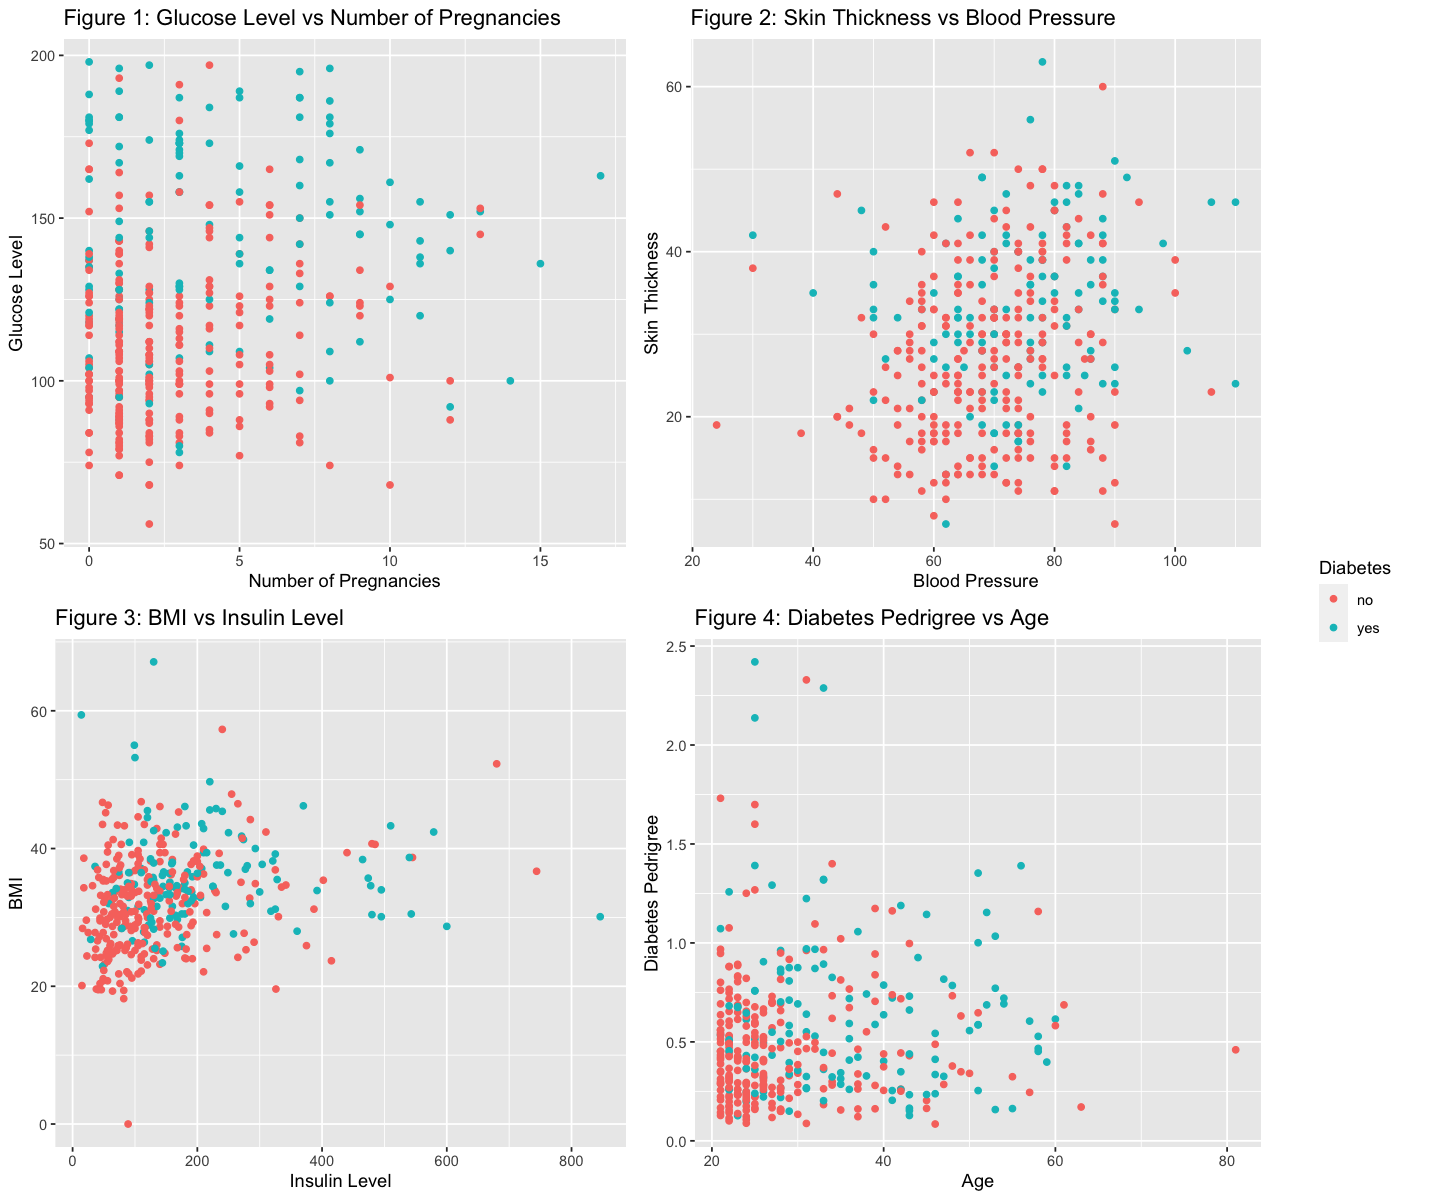

In [56]:
options(repr.plot.width=12, repr.plot.height=10)
library(cowplot)

plot1 <- diabetes_data %>%
    ggplot(aes(x = pregnancies, y = glucose)) +
        geom_point(aes(color = diabetes)) +
        labs(x = "Number of Pregnancies", y = "Glucose Level", colour = "Diabetes") +
        ggtitle("Figure 1: Glucose Level vs Number of Pregnancies")

plot2 <- diabetes_data %>%
    ggplot(aes(x = blood_pressure, y = skin_thickness)) +
        geom_point(aes(color = diabetes)) +
        labs(x = "Blood Pressure", y = "Skin Thickness", colour = "Diabetes") +
        ggtitle("Figure 2: Skin Thickness vs Blood Pressure")

plot3 <- diabetes_data %>%
        ggplot(aes(x = insulin, y = bmi)) +
            geom_point(aes(color = diabetes)) +
            labs(x = "Insulin Level", y = "BMI", colour = "Diabetes") +
            ggtitle("Figure 3: BMI vs Insulin Level")

plot4 <- diabetes_data %>%
        ggplot(aes(x = age, y = diabetes_pedrigree)) +
            geom_point(aes(color = diabetes)) +
            labs(x = "Age", y = "Diabetes Pedrigree", colour = "Diabetes") +
            ggtitle("Figure 4: Diabetes Pedrigree vs Age")

pgrid <- plot_grid(
  plot1 + theme(legend.position="none"),
  plot2 + theme(legend.position="none"),
  plot3 + theme(legend.position="none"),
  plot4 + theme(legend.position="none"),
  ncol = 2)

legend <- get_legend(plot1)
 
plot_grid(pgrid, legend, rel_widths = c(3, .4))

The figures above demonstrate different data measurements and whether they are from patients with or without diabetes. 

In [4]:
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = diabetes)  
diabetes_train <- training(diabetes_split)   
diabetes_test <- testing(diabetes_split)

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")

diabetes_data_recipe <- recipe(diabetes ~ ., data = diabetes_data) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

diabetes_vfold <- vfold_cv(diabetes_train, v = 10, strata = diabetes)

diabetes_fit <- workflow() |>
       add_recipe(diabetes_data_recipe) |>
       add_model(knn_spec) |>
       fit_resamples(resamples = diabetes_vfold)

diabetes_metrics <- collect_metrics(diabetes_fit)
diabetes_metrics

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.7360131,10,0.02350291,Preprocessor1_Model1
roc_auc,binary,0.7730656,10,0.02261379,Preprocessor1_Model1


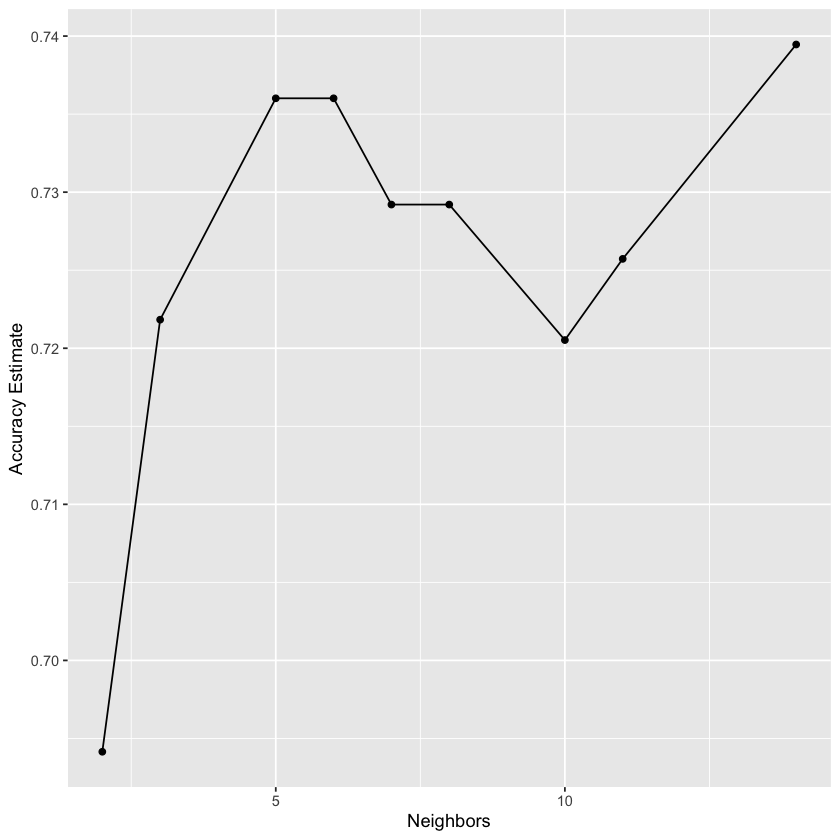

In [14]:
set.seed(2020)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

knn_results <- workflow() |>
       add_recipe(diabetes_data_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = diabetes_vfold, grid = 10) |>
       collect_metrics()

accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
accuracy_versus_k

From the plot, we can see that using K = 14 neighbours results in the highest accuracy. Thus, we will use 14 neighbours for our model.

In [22]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
  set_engine("kknn") |>
  set_mode("classification")

diabetes_fit <- workflow() |>
    add_recipe(diabetes_data_recipe) |>
    add_model(knn_spec) |>
    fit(data = diabetes_train)

diabetes_predictions <- predict(diabetes_fit, diabetes_test) |>
    bind_cols(diabetes_test)

diabetes_metrics <- diabetes_predictions |>
    metrics(truth = diabetes, estimate = .pred_class)

diabetes_conf_mat <- diabetes_predictions |>
    conf_mat(truth = diabetes, estimate = .pred_class)

diabetes_metrics
diabetes_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7395833
kap,binary,0.3842207


          Truth
Prediction  no yes
       no  110  35
       yes  15  32